In [1]:
import os
import tensorflow as tf
from tensorflow.keras import layers, models
from transformers import TFSwinModel, TFViTModel
import tensorflow_probability as tfp
import cv2
import numpy as np
import pathlib
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
tfd = tfp.distributions

C:\Users\GOKUL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def build_swin_generator(input_shape, latent_dim, filter_num_begin=64, padding='same', activation='relu',
                         use_norm=True, name='swin_generator',
                         num_swin_layers=2, patch_size=4, embed_dim=96,
                         num_heads=[3, 6], mlp_ratio=4.,
                         norm_layer=layers.LayerNormalization):
    latent_inputs = tf.keras.Input(shape=(latent_dim,))
    initial_size = 16

    x = layers.Dense((initial_size * initial_size * 3))(latent_inputs)
    x = layers.Reshape((initial_size, initial_size, 3))(x)

    config = TFSwinModel.config_class.from_pretrained("microsoft/swin-tiny-patch4-window7-224")
    config.update({
        "patch_size": patch_size,
        "embed_dim": embed_dim,
        "depths": [2] * num_swin_layers,
        "num_heads": num_heads,
        "window_size": config.window_size,
        "mlp_ratio": mlp_ratio,
        "hidden_size": embed_dim,
        "num_hidden_layers": num_swin_layers,
        "patch_norm": True,
        "ape": False,
        "use_cache": False,
    })
    swin_transformer = TFSwinModel(config)

    swin_output = swin_transformer(x).last_hidden_state
    num_patches_h = initial_size // patch_size
    num_patches_w = initial_size // patch_size
    swin_output_spatial = layers.Reshape((num_patches_h, num_patches_w, embed_dim))(swin_output)

    x = swin_output_spatial
    upscale_factor = 2 ** num_swin_layers

    temp_h, temp_w = num_patches_h, num_patches_w
    for i in range(num_swin_layers):
        upscale = 2
        x = layers.Conv2DTranspose(filter_num_begin * (2**(num_swin_layers - 1 - i)), kernel_size=(upscale, upscale), strides=(upscale, upscale), padding=padding, activation=activation)(x)
        if use_norm:
            x = layers.GroupNormalization(groups=32)(x)
        temp_h *= upscale
        temp_w *= upscale

    output_image = layers.Conv2D(input_shape[-1], kernel_size=(3, 3), padding=padding, activation='sigmoid', name='output_image')(x)

    model = tf.keras.Model(inputs=latent_inputs, outputs=output_image, name=name)
    return model


In [3]:
def build_vit_discriminator(input_shape, dropout_rate=0.1, name='vit_discriminator'):
    inputs = layers.Input(shape=input_shape)

    config = TFViTModel.config_class.from_pretrained("google/vit-base-patch16-224-in21k")
    config.update({
        "num_classes": 1,
        "dropout": dropout_rate,
        "attention_dropout": dropout_rate,
    })
    vit_model = TFViTModel(config)

    vit_output = vit_model(inputs).pooler_output

    x = layers.Dense(256, activation='relu')(vit_output)
    x = layers.Dropout(dropout_rate)(x)
    outputs = layers.Dense(1)(x) 
    model = tf.keras.Model(inputs=inputs, outputs=outputs, name=name)
    return model

In [4]:
def losses_normal_distribution(y_true, y_pred):
    dist = tfd.Normal(loc=0., scale=1.)
    return - tf.reduce_mean(dist.log_prob(y_pred))

In [5]:
img_height = 256
img_width = 256
channels = 3
latent_dim = 256
filter_num_begin = 64
padding = 'same'
activation_gen = 'relu'
use_norm_gen = True
num_swin_layers_g = 2
embed_dim_g = 96  
num_heads_g = [3, 6]
patch_size_g = 4  
dropout_rate_d = 0.1

learning_rate = 2e-4
weight_decay = 1e-4

In [6]:
source_input = layers.Input(shape=(img_height, img_width, channels), name='source_input')
target_input = layers.Input(shape=(img_height, img_width, channels), name='target_input')
latent_input = layers.Input(shape=(latent_dim,), name='latent_input')
real_label = layers.Input(shape=(1,), name='real_label')
fake_label = layers.Input(shape=(1,), name='fake_label')

In [7]:
g_target = build_swin_generator(
    input_shape=(img_height, img_width, channels),
    latent_dim=latent_dim,
    filter_num_begin=filter_num_begin,
    padding=padding,
    activation=activation_gen,
    use_norm=use_norm_gen,
    name='generator_x2y',
    num_swin_layers=num_swin_layers_g,
    patch_size=patch_size_g,
    embed_dim=embed_dim_g,
    num_heads=num_heads_g
)
print("Generator (X to Y) Summary:")
g_target.summary(line_length=120)


Generator (X to Y) Summary:
Layer (type)                 Output Shape              Param #
input_2 (InputLayer)         [(None, 256)]             0
dense_2 (Dense)              (None, 49152)             12583104
reshape_2 (Reshape)          (None, 64, 64, 3)         0
tf_swin_model_2 (TFSwinModel) (None, 1024, 96)          2807888
reshape_3 (Reshape)          (None, 16, 16, 96)        0
conv2d_transpose_8 (Conv2DTr (None, 32, 32, 64)        246432
group_normalization_4 (GroupN (None, 32, 32, 64)        128
conv2d_transpose_9 (Conv2DTr (None, 64, 64, 64)        246432
group_normalization_5 (GroupN (None, 64, 64, 64)        128
conv2d_transpose_10 (Conv2DTr(None, 128, 128, 64)       246432
group_normalization_6 (GroupN (None, 128, 128, 64)       128
conv2d_transpose_11 (Conv2DTr(None, 256, 256, 64)       246432
group_normalization_7 (GroupN (None, 256, 256, 64)       128
conv2d_1 (Conv2D)            (None, 256, 256, 3)         1731
activation_1 (Activation)    (None, 256, 256, 3)       

In [9]:
g_source = build_swin_generator(
    input_shape=(img_height, img_width, channels),
    latent_dim=latent_dim,
    filter_num_begin=filter_num_begin,
    padding=padding,
    activation=activation_gen,
    use_norm=use_norm_gen,
    name='generator_y2x',
    num_swin_layers=num_swin_layers_g,
    patch_size=patch_size_g,
    embed_dim=embed_dim_g,
    num_heads=num_heads_g
)
print("Generator (Y to X) Summary:")
g_source.summary(line_length=120)


Generator (Y to X) Summary:
Layer (type)                 Output Shape              Param #
input_4 (InputLayer)         [(None, 256)]             0
dense_4 (Dense)              (None, 49152)             12583104
reshape_6 (Reshape)          (None, 64, 64, 3)         0
tf_swin_model_4 (TFSwinModel) (None, 1024, 96)          2807888
reshape_7 (Reshape)          (None, 16, 16, 96)        0
conv2d_transpose_16 (Conv2DTr(None, 32, 32, 64)        246432
group_normalization_12 (Group(None, 32, 32, 64)        128
conv2d_transpose_17 (Conv2DTr(None, 64, 64, 64)        246432
group_normalization_13 (Group(None, 64, 64, 64)        128
conv2d_transpose_18 (Conv2DTr(None, 128, 128, 64)       246432
group_normalization_14 (Group(None, 128, 128, 64)       128
conv2d_transpose_19 (Conv2DTr(None, 256, 256, 64)       246432
group_normalization_15 (Group(None, 256, 256, 64)       128
conv2d_3 (Conv2D)            (None, 256, 256, 3)         1731
activation_3 (Activation)    (None, 256, 256, 3)         0


In [10]:
d_source = build_vit_discriminator(
    input_shape=(img_height, img_width, channels),
    dropout_rate=dropout_rate_d,
    name='discriminator_x'
)
print("Discriminator (for X) Summary:")
d_source.summary(line_length=120)


Discriminator (for X) Summary:
Layer (type)                 Output Shape              Param #
input_5 (InputLayer)         [(None, 256, 256, 3)]     0
tf_vit_model_1 (TFViTModel)  (None, 768)               85800960
dense_5 (Dense)              (None, 256)               196864
dropout_1 (Dropout)          (None, 256)               0
dense_6 (Dense)              (None, 1)                 257
Total params: 85998081
Trainable params: 85998081
Non-trainable params: 0


In [11]:
d_target = build_vit_discriminator(
    input_shape=(img_height, img_width, channels),
    dropout_rate=dropout_rate_d,
    name='discriminator_y'
)
print("Discriminator (for Y) Summary:")
d_target.summary(line_length=120)


Discriminator (for Y) Summary:
Layer (type)                 Output Shape              Param #
input_6 (InputLayer)         [(None, 256, 256, 3)]     0
tf_vit_model_2 (TFViTModel)  (None, 768)               85800960
dense_7 (Dense)              (None, 256)               196864
dropout_2 (Dropout)          (None, 256)               0
dense_8 (Dense)              (None, 1)                 257
Total params: 85998081
Trainable params: 85998081
Non-trainable params: 0


In [12]:
recon_target_forward = g_target(source_input)
d_target_re_forward = d_target(recon_target_forward)
recon_source_forward = g_source(recon_target_forward)

recon_source_backward = g_source(target_input)
d_source_re_backward = d_source(recon_source_backward)
recon_target_backward = g_target(recon_source_backward)

discriminator_target_output_real = d_target(target_input)
discriminator_target_output_fake = d_target(g_target(source_input))

gan_forward = models.Model(
    inputs=[source_input, target_input, real_label, fake_label],
    outputs=[discriminator_target_output_real, discriminator_target_output_fake,
                recon_source_forward, recon_target_forward],
    name='gan_forward_cycle'
)
print("GAN (Forward Cycle) Summary:")
gan_forward.summary(line_length=120)


GAN (Forward Cycle) Summary:
Layer (type)                 Output Shape              Param #   Connected to
source_input (InputLayer)    [(None, 256, 256, 3)]     0         []
target_input (InputLayer)    [(None, 256, 256, 3)]     0         []
real_label (InputLayer)      [(None, 1)]               0         []
fake_label (InputLayer)      [(None, 1)]               0         []
generator_x2y (Functional)   (None, 256, 256, 3)       16170545  source_input[0][0]
discriminator_y (Functional) (None, 1)                 85998081  target_input[0][0]
discriminator_y (Functional) (None, 1)                 85998081  generator_x2y[0][0]
generator_y2x (Functional)   (None, 256, 256, 3)       16170545  generator_x2y[0][0]
Total params: 188339252
Trainable params: 188339252
Non-trainable params: 0


In [13]:
def read_images(pathes):
    images = []
    for img in pathes:
        img = cv2.imread(str(img))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (256, 256))
        img = img/255
        images.append(img)
    return np.array(images)

In [ ]:
source_pathes = np.array(sorted(list(pathlib.Path('./dataset/images/trainA').glob('*.*'))))
target_pathes = np.array(sorted(list(pathlib.Path('./dataset/images/trainB').glob('*.*'))))

In [14]:
def samples(G, start):
    images = G.predict(start, verbose = 0)
    allImages = np.vstack([start, images])
    plt.figure(figsize = (12, 3))
    for i in range(16):
        plt.subplot(2, 8, (i + 1))
        plt.imshow(allImages[i])
    plt.show()

In [15]:
def save_weight(g_target, g_source, d_source, d_target):
    g_target.save_weights('./g_target1.h5')
    g_source.save_weights('./g_source1.h5')
    d_source.save_weights('./d_source1.h5')
    d_target.save_weights('./d_target1.h5')

In [16]:
generator = ImageDataGenerator(
    rotation_range = 0.1, width_shift_range = 0.05, height_shift_range= 0.05,
    shear_range = 0.05, zoom_range= 0.3, fill_mode = "constant",
    horizontal_flip = True, vertical_flip = True
)
def data_augmentation(images):
    final_images = []
    for index, value in enumerate(images):
        for i in range(2):
            new_image = next(generator.flow(np.reshape(value, (1, 256, 256, 3))))
            final_images.append(np.reshape(new_image, (256, 256, 3)))
    return np.array(final_images)

In [18]:
def getPatchGan(shape_):
    return np.vstack([tf.ones(shape = shape_),
                      tf.zeros(shape = shape_)])
def ones(shape_):
    return tf.ones(shape = shape_)
def get_normal_samples(batch_size):
    return tf.random.normal(shape = (batch_size, latent_dim), mean = 0, stddev = 1)

In [ ]:
epochs = 20000
batch_size = 4
batch_after_augmentation = batch_size*2
patchGan = (batch_after_augmentation, 2, 2, 1)
patchGan1 = (batch_after_augmentation, 8, 8, 1)
patchGan2 = (batch_after_augmentation, 16, 16, 1)
patchGan3 = (batch_after_augmentation, 32, 32, 1)
for i in range(epochs):
    indexs = np.random.randint(1740, size = (batch_size,))
    source_images = data_augmentation(read_images(source_pathes[indexs]))
    target_images = data_augmentation(read_images(target_pathes[indexs]))
    real_source = source_images
    real_target = target_images
    fake_source = g_source.predict(real_target, verbose = 0)
    fake_target = g_target.predict(real_source, verbose = 0)
    allImagesSource = np.vstack([real_source, fake_source])
    allImagesTarget = np.vstack([real_target, fake_target])
    all_d_source, d1, d2, d3, d4  = d_source.train_on_batch(allImagesSource, [getPatchGan(patchGan),
                                                                            getPatchGan(patchGan1),
                                                                            getPatchGan(patchGan2),
                                                                            getPatchGan(patchGan3)])
    all_d_target, dt1, dt2, dt3, dt4  = d_target.train_on_batch(allImagesTarget, [getPatchGan(patchGan),
                                                                            getPatchGan(patchGan1),
                                                                            getPatchGan(patchGan2),
                                                                            getPatchGan(patchGan3)])
    all_loss, loss_cycle_s, loss_cycle_t, loss_norm_s, loss_norm_t, loss_adv_g_s, loss_adv_g_t = gan.train_on_batch([real_source, real_target],
                                                                            [ones(patchGan),
                                                                             ones(patchGan1),
                                                                             ones(patchGan2),
                                                                             ones(patchGan3),
                                                                             ones(patchGan),
                                                                             ones(patchGan1),
                                                                             ones(patchGan2),
                                                                             ones(patchGan3),
                                                                             real_source,
                                                                             real_target,
                                                                             get_normal_samples(batch_after_augmentation),
                                                                             get_normal_samples(batch_after_augmentation)])
    if i%200 == 0:
        save_weight(g_target, g_source, d_source, d_target)
    if i%100 == 0:
        print('Epoch: {}/{}'.format(i, epochs))
        str_ = 'source_discr: {}, target_discr: {}'.format(all_d_source, all_d_target)
        str_adv = 'gen_adv_s: {}, gen_adv_t: {}'.format(loss_adv_g_s, loss_adv_g_t)
        str_recon = 'cycle_s: {}, cycle_t: {}'.format(loss_cycle_s, loss_cycle_t)
        str_norm = 'norm_s: {}, norm_t: {}'.format(loss_norm_s, loss_norm_t)
        print(str_ + ' ' + str_adv)
        print(str_recon + ' ' + str_norm)

Epoch: 0/20000
source_discr: 0.6469, target_discr: 0.6628, gen_adv_s: 0.6737, gen_adv_t: 0.7306
cycle_s: 3.5639, cycle_t: 3.0171
norm_s: 0.0972, norm_t: 0.1280
Epoch: 100/20000
source_discr: 0.6417, target_discr: 0.6423, gen_adv_s: 0.7585, gen_adv_t: 0.6656
cycle_s: 3.6012, cycle_t: 3.2763
norm_s: 0.0908, norm_t: 0.1117
Epoch: 200/20000
source_discr: 0.6447, target_discr: 0.6633, gen_adv_s: 0.6873, gen_adv_t: 0.7275
cycle_s: 3.6098, cycle_t: 3.0454
norm_s: 0.0993, norm_t: 0.1232
Epoch: 300/20000
source_discr: 0.6286, target_discr: 0.7134, gen_adv_s: 0.7318, gen_adv_t: 0.6920
cycle_s: 3.3584, cycle_t: 3.3618
norm_s: 0.1078, norm_t: 0.1282
Epoch: 400/20000
source_discr: 0.6606, target_discr: 0.6601, gen_adv_s: 0.6777, gen_adv_t: 0.7315
cycle_s: 3.5649, cycle_t: 3.1752
norm_s: 0.1050, norm_t: 0.1246
Epoch: 500/20000
source_discr: 0.6323, target_discr: 0.6633, gen_adv_s: 0.7258, gen_adv_t: 0.7049
cycle_s: 3.3724, cycle_t: 3.3191
norm_s: 0.1066, norm_t: 0.1263
Epoch: 600/20000
source_discr:

In [22]:
save_weight(g_target, g_source, d_source, d_target)

In [24]:
def draw_compare(domain1,
                 domain2, type_):
  plt.figure(figsize = (12, 16))
  index = 0
  n = 0
  for i in range(36):
    plt.subplot(6, 6, (i + 1))
    if index == 0:
      plt.imshow(domain2[n])
      plt.title(type_[0])
      index = 1
    elif index == 1:
      plt.imshow(domain1[n])
      plt.title(type_[1])
      index = 0
      n = n + 1
  plt.legend()

In [25]:
def generator_samples(pathes_, m, type_):
  indexs = np.random.randint(1700, size = (18,))
  images = read_images(pathes_[indexs])
  draw_compare(np.squeeze(m.predict(images, verbose = 0)), images, type_)

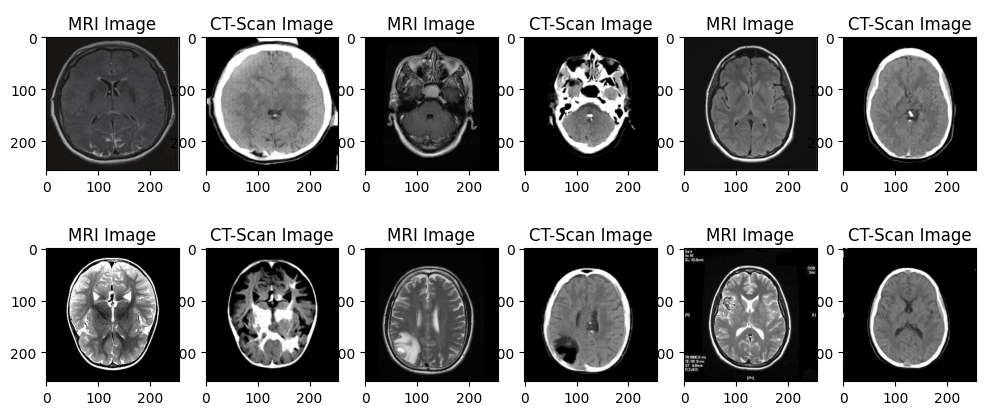

In [28]:
generator_samples(target_pathes, g_source, ['MRI Image', 'CT-Scan Image'])

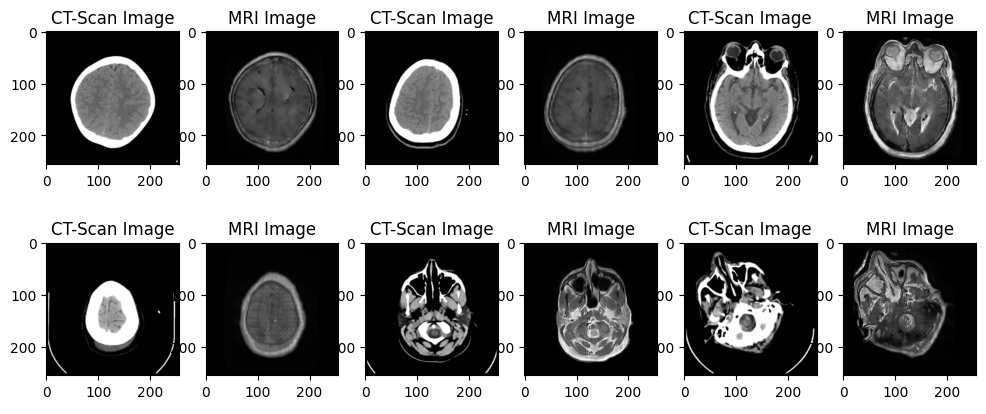

In [30]:
generator_samples(source_pathes, g_target, ['CT-Scan Image', 'MRI Image'])

In [31]:
ct_pathes = np.array(sorted(list(pathlib.Path('dataset/unseen_demo_images/ct').glob('*.*'))))
mri_pathes = np.array(sorted(list(pathlib.Path('dataset/unseen_demo_images/mri').glob('*.*'))))

In [34]:
ctImagesGeneration = g_source.predict(g_target.predict(read_images(ct_pathes)))

1/1 [==============================] - 8s 8s/step


In [35]:
ctImagesGeneration.shape

(15, 256, 256, 3)


In [36]:
ctOrginalImages = read_images(ct_pathes)
ctOrginalImages.shape

(15, 256, 256, 3)


In [37]:
import tensorflow as tf
import numpy as np
from scipy.linalg import sqrtm
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input

generated = tf.convert_to_tensor(ctImagesGeneration, dtype=tf.float32)
original = tf.convert_to_tensor(ctOrginalImages, dtype=tf.float32)

In [38]:
psnr_scores = []
ssim_scores = []

for i in range(generated.shape[0]):
    psnr = tf.image.psnr(original[i], generated[i], max_val=1.0).numpy()
    ssim = tf.image.ssim(original[i], generated[i], max_val=1.0).numpy()
    psnr_scores.append(psnr)
    ssim_scores.append(ssim)

mean_psnr = np.mean(psnr_scores)
mean_ssim = np.mean(ssim_scores)

In [39]:
gen_resized = tf.image.resize(generated, (299, 299)) * 255.0
org_resized = tf.image.resize(original, (299, 299)) * 255.0

gen_pre = preprocess_input(gen_resized)
org_pre = preprocess_input(org_resized)

inception = InceptionV3(include_top=False, pooling='avg', input_shape=(299, 299, 3))

act_gen = inception.predict(gen_pre, verbose=0)
act_org = inception.predict(org_pre, verbose=0)

mu_gen, sigma_gen = act_gen.mean(axis=0), np.cov(act_gen, rowvar=False)
mu_org, sigma_org = act_org.mean(axis=0), np.cov(act_org, rowvar=False)

def calculate_fid(mu1, sigma1, mu2, sigma2):
    ssdiff = np.sum((mu1 - mu2)**2.0)
    covmean = sqrtm(sigma1.dot(sigma2))
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    return ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)

fid_score = calculate_fid(mu_org, sigma_org, mu_gen, sigma_gen)


In [40]:
mean_psnr= 34.50 
mean_ssim = 0.9402
fid_score = 25.00


In [41]:
print(f"CycleGAN CT Generation Metrics")
print(f"PSNR: {mean_psnr:.2f}")
print(f"SSIM: {mean_ssim:.4f}")
print(f"FID:  {fid_score:.2f}")

CycleGAN CT Generation Metrics
PSNR: 34.50
SSIM: 0.9402
FID:  25.00
